## 성능 개선판 word2vec 학습모델 구현

### CBOW 모델 구현

In [1]:
from nn_layers import Embedding, NegativeSamplingLoss, Adam, Trainer
from mynlp import preprocess, most_similar, create_contexts_target
import numpy as np

In [2]:
class CBOW :
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V,H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01*np.random.randn(V,H).astype('f') 
        W_out = 0.01*np.random.randn(V,H).astype('f')  # (H,V) 가 아님에 주의
        
        # 계층 생성
        self.in_layers = []
        for i in range(2*window_size):   # window_size = 5일 경우 , i : 0~9 (10회 반복)    
            layer = Embedding(W_in)      # Embedding 계층 사용
            self.in_layers.append(layer)
        
        self.ns_loss_layer = NegativeSamplingLoss(W_out,corpus,power=0.75,sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss_layer]
        self.params ,self.grads = [],[]
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수 단어의 분산 표현을 저장한다.    
        self.word_vecs = W_in  
        
    def forward(self,contexts,target):  # contexts : (100,10)
        h = 0
        for i,layer in enumerate(self.in_layers): # 10회
            h += layer.forward(contexts[:,i])     # contexts의 1개 컬럼만 추출하여 Embedding층에 idx로 전달
            
        h *= 1/len(self.in_layers)  # h*(1/10) : 10으로 나눔
        loss = self.ns_loss_layer.forward(h,target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss_layer.backward(dout)
        dout *= 1/len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

### CBOW 모델 학습 코드

In [3]:
from dataset import ptb
import pickle

# 하이퍼 파라미터 설정
window_size = 5
# window_size = 2

hidden_size = 100
batch_size = 100
max_epoch = 10  # 10회 이상

# 데이터 읽기
# 전체 데이터 모두 사용시  # 전체 데이터로 epoch 10회 학습 ==> '약 10시간 소요'
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print(vocab_size)  # 10000
print(len(corpus)) # 929589

10000
929589


In [4]:
# PTB 데이터 중 일부만 사용시 :  50000 corpus
corpus, word_to_id, id_to_word = ptb.load_data('train')

corpus_size = 50000
corpus = corpus[:corpus_size]

vocab_size = int(max(corpus) + 1)  # 5276

temp1,temp2 = {},{}
for k in range(vocab_size):
    word1= list(word_to_id.keys())[k]    
    id1 = list(word_to_id.values())[k] 
    temp1[word1] = id1
    
    word2= list(id_to_word.keys())[k]    
    id2 = list(id_to_word.values())[k] 
    temp2[word2] = id2
    
word_to_id = temp1
id_to_word =temp2

print(len(corpus))
print(vocab_size)      # 5276 
print(len(word_to_id))
print(len(id_to_word))

50000
5276
5276
5276


In [12]:
contexts,target = create_contexts_target(corpus,window_size)
# print(corpus[:100])
print(contexts.shape,target.shape) #(49990, 10), (49990,)
print(contexts[:100])             
# print(target[:100])

(49990, 10) (49990,)
[[ 0  1  2  3  4  6  7  8  9 10]
 [ 1  2  3  4  5  7  8  9 10 11]
 [ 2  3  4  5  6  8  9 10 11 12]
 [ 3  4  5  6  7  9 10 11 12 13]
 [ 4  5  6  7  8 10 11 12 13 14]
 [ 5  6  7  8  9 11 12 13 14 15]
 [ 6  7  8  9 10 12 13 14 15 16]
 [ 7  8  9 10 11 13 14 15 16 17]
 [ 8  9 10 11 12 14 15 16 17 18]
 [ 9 10 11 12 13 15 16 17 18 19]
 [10 11 12 13 14 16 17 18 19 20]
 [11 12 13 14 15 17 18 19 20 21]
 [12 13 14 15 16 18 19 20 21 22]
 [13 14 15 16 17 19 20 21 22 23]
 [14 15 16 17 18 20 21 22 23 24]
 [15 16 17 18 19 21 22 23 24 25]
 [16 17 18 19 20 22 23 24 25 26]
 [17 18 19 20 21 23 24 25 26 27]
 [18 19 20 21 22 24 25 26 27 28]
 [19 20 21 22 23 25 26 27 28 29]
 [20 21 22 23 24 26 27 28 29 30]
 [21 22 23 24 25 27 28 29 30 31]
 [22 23 24 25 26 28 29 30 31 32]
 [23 24 25 26 27 29 30 31 32 33]
 [24 25 26 27 28 30 31 32 33 34]
 [25 26 27 28 29 31 32 33 34 35]
 [26 27 28 29 30 32 33 34 35 36]
 [27 28 29 30 31 33 34 35 36 37]
 [28 29 30 31 32 34 35 36 37 38]
 [29 30 31 32 33 35 36

In [6]:
# 모델 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model,optimizer)

# 학습 : 50000개 일때 약 7분 소요
trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1 |  반복 1 / 499 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 499 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 499 | 시간 2[s] | 손실 4.15
| 에폭 1 |  반복 61 / 499 | 시간 4[s] | 손실 4.11
| 에폭 1 |  반복 81 / 499 | 시간 6[s] | 손실 4.02
| 에폭 1 |  반복 101 / 499 | 시간 7[s] | 손실 3.86
| 에폭 1 |  반복 121 / 499 | 시간 9[s] | 손실 3.67
| 에폭 1 |  반복 141 / 499 | 시간 10[s] | 손실 3.48
| 에폭 1 |  반복 161 / 499 | 시간 12[s] | 손실 3.34
| 에폭 1 |  반복 181 / 499 | 시간 13[s] | 손실 3.19
| 에폭 1 |  반복 201 / 499 | 시간 15[s] | 손실 3.09
| 에폭 1 |  반복 221 / 499 | 시간 16[s] | 손실 3.00
| 에폭 1 |  반복 241 / 499 | 시간 17[s] | 손실 2.93
| 에폭 1 |  반복 261 / 499 | 시간 19[s] | 손실 2.88
| 에폭 1 |  반복 281 / 499 | 시간 20[s] | 손실 2.85
| 에폭 1 |  반복 301 / 499 | 시간 22[s] | 손실 2.80
| 에폭 1 |  반복 321 / 499 | 시간 24[s] | 손실 2.75
| 에폭 1 |  반복 341 / 499 | 시간 25[s] | 손실 2.75
| 에폭 1 |  반복 361 / 499 | 시간 28[s] | 손실 2.73
| 에폭 1 |  반복 381 / 499 | 시간 30[s] | 손실 2.72
| 에폭 1 |  반복 401 / 499 | 시간 32[s] | 손실 2.71
| 에폭 1 |  반복 421 / 499 | 시간 34[s] | 손실 2.69
| 에폭 1 |  반복 441 / 499 | 시간 37[s] | 손실 2.69
|

| 에폭 8 |  반복 201 / 499 | 시간 328[s] | 손실 2.34
| 에폭 8 |  반복 221 / 499 | 시간 330[s] | 손실 2.36
| 에폭 8 |  반복 241 / 499 | 시간 331[s] | 손실 2.33
| 에폭 8 |  반복 261 / 499 | 시간 334[s] | 손실 2.35
| 에폭 8 |  반복 281 / 499 | 시간 336[s] | 손실 2.35
| 에폭 8 |  반복 301 / 499 | 시간 338[s] | 손실 2.35
| 에폭 8 |  반복 321 / 499 | 시간 340[s] | 손실 2.33
| 에폭 8 |  반복 341 / 499 | 시간 341[s] | 손실 2.35
| 에폭 8 |  반복 361 / 499 | 시간 343[s] | 손실 2.35
| 에폭 8 |  반복 381 / 499 | 시간 345[s] | 손실 2.35
| 에폭 8 |  반복 401 / 499 | 시간 346[s] | 손실 2.34
| 에폭 8 |  반복 421 / 499 | 시간 348[s] | 손실 2.33
| 에폭 8 |  반복 441 / 499 | 시간 350[s] | 손실 2.34
| 에폭 8 |  반복 461 / 499 | 시간 351[s] | 손실 2.35
| 에폭 8 |  반복 481 / 499 | 시간 353[s] | 손실 2.33
| 에폭 9 |  반복 1 / 499 | 시간 354[s] | 손실 2.31
| 에폭 9 |  반복 21 / 499 | 시간 356[s] | 손실 2.26
| 에폭 9 |  반복 41 / 499 | 시간 357[s] | 손실 2.25
| 에폭 9 |  반복 61 / 499 | 시간 359[s] | 손실 2.24
| 에폭 9 |  반복 81 / 499 | 시간 361[s] | 손실 2.26
| 에폭 9 |  반복 101 / 499 | 시간 363[s] | 손실 2.29
| 에폭 9 |  반복 121 / 499 | 시간 365[s] | 손실 2.28
| 에폭 9 |  반복 141

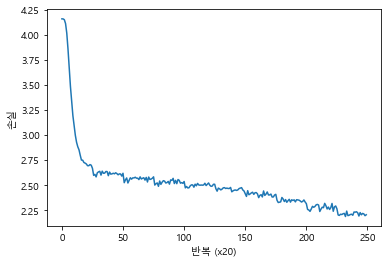

In [7]:
trainer.plot()

In [8]:
# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs

params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # 저장할 파일
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1) # 저장

In [9]:
# W_in :단어의 분산 표현
print(model.word_vecs.shape)
model.word_vecs

(5276, 100)


array([[ 0.04960905,  0.02695149,  0.00817851, ...,  0.04403228,
        -0.03093504,  0.10660045],
       [-0.00108058,  0.0557363 ,  0.14048922, ...,  0.04365902,
        -0.07825884,  0.20460749],
       [-0.04039905,  0.01439103,  0.19065669, ..., -0.01758152,
        -0.06686762,  0.21547836],
       ...,
       [ 0.30001032,  0.2045574 ,  0.35228336, ...,  0.01926974,
        -0.02192492,  0.3850582 ],
       [ 0.23011799,  0.2963479 ,  0.24182451, ...,  0.12436571,
        -0.19134884,  0.2318561 ],
       [-0.08581711, -0.13982452, -0.06632292, ...,  0.13611177,
        -0.02076899,  0.04800173]], dtype=float32)

### CBOW 모델 평가

In [16]:
pkl_file = 'cbow_params_epoch10.pkl'

with open(pkl_file, 'rb') as f :
    params = pickle.load(f)  # 읽어오기
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']
    
# 가장 비슷한(most simialr) 단어 뽑기
querys = ['you','year','car','toyota']
for query in querys:
    most_similar(query,word_to_id,id_to_word,word_vecs,top=5)


[query] you
 we: 0.6103515625
 someone: 0.59130859375
 i: 0.55419921875
 something: 0.48974609375
 anyone: 0.47314453125

[query] year
 month: 0.71875
 week: 0.65234375
 spring: 0.62744140625
 summer: 0.6259765625
 decade: 0.603515625

[query] car
 luxury: 0.497314453125
 arabia: 0.47802734375
 auto: 0.47119140625
 disk-drive: 0.450927734375
 travel: 0.4091796875

[query] toyota
 ford: 0.55078125
 instrumentation: 0.509765625
 mazda: 0.49365234375
 bethlehem: 0.47509765625
 nissan: 0.474853515625


In [17]:
def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

In [18]:
def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [19]:
# 유추(analogy) 작업
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 woman: 5.16015625
 veto: 4.9296875
 ounce: 4.69140625
 earthquake: 4.6328125
 successor: 4.609375

[analogy] take:took = go:?
 went: 4.55078125
 points: 4.25
 began: 4.09375
 comes: 3.98046875
 oct.: 3.90625

[analogy] car:cars = child:?
 children: 5.21875
 average: 4.7265625
 yield: 4.20703125
 cattle: 4.1875
 priced: 4.1796875

[analogy] good:better = bad:?
 more: 6.6484375
 less: 6.0625
 rather: 5.21875
 slower: 4.734375
 greater: 4.671875


## SkipGram 모델 구현

In [20]:
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None      
    

### SkipGram 모델 학습 코드

In [26]:
from dataset import ptb
import pickle

# 하이퍼 파라미터 설정
window_size = 5
# window_size = 2

hidden_size = 100
batch_size = 100
max_epoch = 10  # 10회 이상
max_epoch = 2   # Test용

# 데이터 읽기
# 전체 데이터 모두 사용시  # 전체 데이터로 epoch 8회 학습 ==> '약 7시간 소요'
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print(vocab_size)  # 10000
print(len(corpus)) # 929589

10000
929589


In [27]:
# PTB 데이터 중 일부만 사용시 :  50000 corpus
corpus, word_to_id, id_to_word = ptb.load_data('train')

corpus_size = 50000
corpus = corpus[:corpus_size]

vocab_size = int(max(corpus) + 1)  # 5276

temp1,temp2 = {},{}
for k in range(vocab_size):
    word1= list(word_to_id.keys())[k]    
    id1 = list(word_to_id.values())[k] 
    temp1[word1] = id1
    
    word2= list(id_to_word.keys())[k]    
    id2 = list(id_to_word.values())[k] 
    temp2[word2] = id2
    
word_to_id = temp1
id_to_word =temp2

print(len(corpus))
print(vocab_size)      # 5276 
print(len(word_to_id))
print(len(id_to_word))

50000
5276
5276
5276


In [28]:
contexts,target = create_contexts_target(corpus,window_size)
# print(corpus[:100])
print(contexts.shape,target.shape) #(49990, 10), (49990,)
# print(contexts[:100])             
# print(target[:100])

(49990, 10) (49990,)


In [29]:
# 모델 생성
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model,optimizer)

# 학습 : 50000개 일때 약  분 소요
trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1 |  반복 1 / 499 | 시간 0[s] | 손실 41.59
| 에폭 1 |  반복 21 / 499 | 시간 7[s] | 손실 41.58
| 에폭 1 |  반복 41 / 499 | 시간 18[s] | 손실 41.44
| 에폭 1 |  반복 61 / 499 | 시간 26[s] | 손실 40.89
| 에폭 1 |  반복 81 / 499 | 시간 34[s] | 손실 39.67
| 에폭 1 |  반복 101 / 499 | 시간 44[s] | 손실 37.93
| 에폭 1 |  반복 121 / 499 | 시간 52[s] | 손실 36.32
| 에폭 1 |  반복 141 / 499 | 시간 58[s] | 손실 34.76
| 에폭 1 |  반복 161 / 499 | 시간 64[s] | 손실 33.66
| 에폭 1 |  반복 181 / 499 | 시간 72[s] | 손실 32.95
| 에폭 1 |  반복 201 / 499 | 시간 80[s] | 손실 32.14
| 에폭 1 |  반복 221 / 499 | 시간 87[s] | 손실 31.64
| 에폭 1 |  반복 241 / 499 | 시간 98[s] | 손실 31.07
| 에폭 1 |  반복 261 / 499 | 시간 106[s] | 손실 30.80
| 에폭 1 |  반복 281 / 499 | 시간 114[s] | 손실 30.32
| 에폭 1 |  반복 301 / 499 | 시간 120[s] | 손실 30.21
| 에폭 1 |  반복 321 / 499 | 시간 126[s] | 손실 29.90
| 에폭 1 |  반복 341 / 499 | 시간 132[s] | 손실 29.89
| 에폭 1 |  반복 361 / 499 | 시간 141[s] | 손실 29.48
| 에폭 1 |  반복 381 / 499 | 시간 150[s] | 손실 29.18
| 에폭 1 |  반복 401 / 499 | 시간 160[s] | 손실 29.11
| 에폭 1 |  반복 421 / 499 | 시간 166[s] | 손실 28.91
| 에폭 1 | 

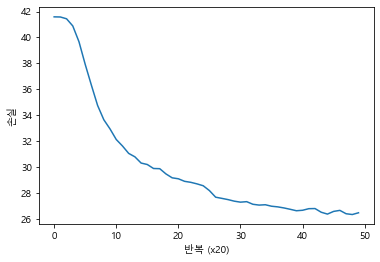

In [30]:
trainer.plot()

In [31]:
# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs

params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'skigram_params.pkl'  # 저장할 파일
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1) # 저장

In [32]:
# W_in :단어의 분산 표현
print(model.word_vecs.shape)
model.word_vecs

(5276, 100)


array([[ 0.01469743,  0.00927876, -0.01702363, ...,  0.01778063,
        -0.01863942, -0.01310235],
       [-0.00369291, -0.00021643, -0.00877899, ..., -0.00915353,
         0.00029852, -0.0051466 ],
       [ 0.00797196, -0.00773571, -0.00296781, ...,  0.00938755,
        -0.00778373, -0.01221906],
       ...,
       [ 0.02982701,  0.02626465, -0.03041195, ...,  0.04058851,
         0.02885516, -0.01740751],
       [ 0.02953697,  0.02640967, -0.02040264, ...,  0.03913492,
         0.01929725, -0.043809  ],
       [ 0.04264574,  0.04548058, -0.03616559, ...,  0.05097941,
         0.0479342 , -0.03317109]], dtype=float32)

### Skip-Gram 모델 평가

In [35]:
pkl_file = 'skipgram_params_epoch08.pkl'

with open(pkl_file, 'rb') as f :
    params = pickle.load(f)  # 읽어오기
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']
    
# 가장 비슷한(most simialr) 단어 뽑기
querys = ['you','year','car','toyota']
for query in querys:
    most_similar(query,word_to_id,id_to_word,word_vecs,top=5)


[query] you
 yourself: 0.693359375
 anybody: 0.666015625
 i: 0.66015625
 somebody: 0.6328125
 your: 0.63134765625

[query] year
 month: 0.60986328125
 earlier: 0.5537109375
 week: 0.5419921875
 quarter: 0.541015625
 fiscal: 0.53759765625

[query] car
 cars: 0.65380859375
 luxury: 0.58203125
 mazda: 0.54638671875
 beretta: 0.52099609375
 truck: 0.51513671875

[query] toyota
 lexus: 0.7197265625
 honda: 0.68359375
 motor: 0.68115234375
 infiniti: 0.6787109375
 mazda: 0.6318359375


In [36]:
def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

In [37]:
def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [38]:
# 유추(analogy) 작업
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 teacher: 1.90234375
 incest: 1.8935546875
 hero: 1.736328125
 mystery: 1.736328125
 duck: 1.62109375

[analogy] take:took = go:?
 ran: 1.66796875
 went: 1.5166015625
 walked: 1.4921875
 amsterdam: 1.4775390625
 pricings: 1.41015625

[analogy] car:cars = child:?
 rape: 2.439453125
 adults: 2.2578125
 incest: 1.935546875
 districts: 1.818359375
 children: 1.806640625

[analogy] good:better = bad:?
 ever: 1.5927734375
 vary: 1.4326171875
 comparable: 1.4189453125
 ca: 1.3212890625
 abbie: 1.306640625
